In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from collections import defaultdict

In [2]:
df = pd.read_csv('table_for_prediction_updated_with_diff_target.csv')

In [3]:
df

Session          Form   Grade   WCPM    Acc  Comp  Exp  level  \
0       13107  Grade4Winter  Grade4   72.0  0.992   2.4  3.4     11   
1       13111  Grade4Winter  Grade4   74.0  0.939   3.3  3.3     12   
2       13112  Grade4Winter  Grade4   58.0  0.877   3.7  3.3     10   
3       13113  Grade4Winter  Grade4   57.0  0.854   2.4  3.1     10   
4       13116  Grade4Winter  Grade4   61.0  0.902   4.4  2.9     10   
...       ...           ...     ...    ...    ...   ...  ...    ...   
1198    53803  Grade4Spring  Grade4  122.0  1.000   4.4  3.7     16   
1199    53945  Grade1Winter  Grade1   64.0  1.000   7.0  2.2      9   
1200    54096  Grade4Winter  Grade4  124.0  0.997   5.7  3.6     17   
1201    54166  Grade4Spring  Grade4  124.0  0.996   6.5  3.6     16   
1202    54195    Grade4Fall  Grade4   82.0  0.695   2.0  2.3     12   

      WCPM_zscore  Acc_zscore  ...  gyorP  gyorQ  mlevel_numeric  \
0       -0.690871    0.517458  ...      3    3.0              11   
1       -0.620918   -0.067908  ...      3    3.0              12   
2       -1.180540   -0.752676  ...      0    2.0              10   
3       -1.215517   -1.006703  ...      3    3.0              10   
4       -1.075611   -0.476560  ...      3    2.0              10   
...           ...         ...  ...    ...    ...             ...   
1198     0.404977    0.676739  ...      3    3.0              16   
1199     0.007175    0.877031  ...      3    3.0               9   
1200     1.127903    0.572681  ...      3    3.0              17   
1201     0.461105    0.624682  ...      3    3.0              16   
1202    -0.572132   -3.891709  ...      3    3.0              12   

      form_numeric  mlevel_form_diff  text_is_above_level      Acc4   AvgSpan  \
0               16                -5                    0  0.968382       NaN   
1               16                -4                    0  0.777432       NaN   
2               16                -6                    0  0.591559       NaN   
3               16                -6                    0  0.531902       NaN   
4               16                -6                    0  0.661951       NaN   
...            ...               ...                  ...       ...       ...   
1198            17                -1                    0  1.000000  1.000000   
1199             6                 3                    1  1.000000  1.000000   
1200            16                 1                    1  0.988054  1.000000   
1201            17                -1                    0  0.984096  1.000000   
1202            15                -3                    0  0.233313  0.970224   

      AccOverSpanNonSW  DiffTarget  
0             0.000000       Right  
1             0.000000       Right  
2             0.000000       Right  
3             0.000000        Hard  
4             0.000000       Right  
...                ...         ...  
1198          0.967213       Right  
1199          0.909091       Right  
1200          0.921875       Right  
1201          0.950820       Right  
1202          0.806818        Easy  

[1203 rows x 34 columns]

In [3]:
def get_max(lst):
    return sorted(lst)[int(len(lst) * .98)] # get rid of outliers, hacky

def get_combination_string(combination, metrics):
    output = ['{:.2f} * {}'.format(c, m)  for c, m in zip(combination, metrics)]
    return ' + '.join(output)

def bins_counts_overlap(bins_counts):
    gyor_val_combinations = itertools.combinations(bins_counts.keys(), 2)
    comb_to_jaccard = {}
    for comb in gyor_val_combinations:
        bins_A = bins_counts[comb[0]]
        bins_B = bins_counts[comb[1]]
        min_idx = min(min(bins_A), min(bins_B))
        max_idx = max(max(bins_A), max(bins_B))
        all_overlap = 0
        all_unique = 0
        for i in range(min_idx, max_idx + 1):
            A_count = bins_A.count(i)
            B_count = bins_B.count(i)
            overlap = min(A_count, B_count)
            unique = max(A_count, B_count) - overlap
            all_overlap += overlap
            all_unique += unique
        comb_to_jaccard[comb] = all_overlap / (all_overlap + all_unique)
    return comb_to_jaccard

In [4]:
df['AccOverSpanNonSW'] = df.AccOverSpanNonSW.apply(lambda x: x ** 2)

In [108]:
def plot_linear_combinations(grade, metrics=['WCPM', 'Acc4'], grain=4):
    ct = 1
    df_grade = df.loc[df.Form == grade].fillna(0)
    df_grade = df_grade.copy(deep=True)
    for metric in metrics:
        df_grade[metric + '_scaled'] = np.interp(
            df_grade[metric], 
            (df_grade[metric].min(), get_max(df_grade[metric])), 
            (0, 1))
    intervals = list(np.linspace(0, 1, grain))
    df_values_submatrix = np.array(df_grade[[metric + '_scaled' for metric in metrics]])
    interval_combinations = itertools.product(*[intervals for _ in range(len(metrics))])
    comb_to_average_jaccard = {}
    
    best_combination = None
    lowest_jaccard = 1
    for combination in interval_combinations:
        if sum(combination) == 0:
            continue
        combination_vector = np.array(combination).reshape((len(combination), 1))
        df_grade['lin_comb'] = df_values_submatrix @ combination_vector
#         plt.figure(figsize=(5, 3))
        
        lin_comb_min, lin_comb_max = min(df_grade.lin_comb), max(df_grade.lin_comb)
        bin_step = .2
        bins = [lin_comb_min - 0.001 + i * bin_step for i in range(0, int((lin_comb_max - lin_comb_min) / bin_step) + 2)]
        bins_counts = {}
        
        for gyor_val, gyor_color in zip(
                [3, 2, 1, 0], 
                ['lightgreen', 'gold', 'darkorange', 'firebrick']):
            df_grade_selected = df_grade.loc[df_grade.gyorJ == gyor_val]
            binned_lin_comb = np.digitize(df_grade_selected.lin_comb, bins, right=True)
            bins_counts[gyor_val] = sorted(binned_lin_comb)
#             sns.distplot(df_grade_selected.lin_comb, color=gyor_color, hist_kws=dict(alpha=.2))\
#                 .set_title(grade + '\n' + get_combination_string(combination, metrics))
        jaccards = bins_counts_overlap(bins_counts)
        avg_jaccard = np.mean([y for x, y in jaccards.items()])
        comb_to_average_jaccard[get_combination_string(combination, metrics)] = avg_jaccard
        if avg_jaccard < lowest_jaccard:
            lowest_jaccard = avg_jaccard
            best_combination = combination
            
    combination_vector = np.array(best_combination).reshape((len(best_combination), 1))
    df_grade['lin_comb'] = df_values_submatrix @ combination_vector
    plt.figure(figsize=(8, 5))

    lin_comb_min, lin_comb_max = min(df_grade.lin_comb), max(df_grade.lin_comb)
    bin_step = .2
    bins = [lin_comb_min - 0.001 + i * bin_step for i in range(0, int((lin_comb_max - lin_comb_min) / bin_step) + 2)]
    bins_counts = {}
    max_lin_comb_val = -1
    for gyor_val, gyor_color in zip(
            [3, 2, 1, 0], 
            ['lightgreen', 'gold', 'darkorange', 'firebrick']):
        df_grade_selected = df_grade.loc[df_grade.gyorJ == gyor_val]
        
        binned_lin_comb = np.digitize(df_grade_selected.lin_comb, bins, right=True)
        bins_counts[gyor_val] = sorted(binned_lin_comb)
        max_lin_comb_val = max(max_lin_comb_val, max(df_grade_selected.lin_comb))
        sns.distplot(
            df_grade_selected.lin_comb,
            color=gyor_color,
            hist_kws=dict(alpha=.2)).set_title(grade + '\n' + get_combination_string(best_combination, metrics))
    plt.xticks(np.arange(0, int(max_lin_comb_val) + 1, .5))
#     plt.savefig(grade + '.png')
#     jaccards = bins_counts_overlap(bins_counts)
#     avg_jaccard = np.mean([y for x, y in jaccards.items()])
#     comb_to_average_jaccard[get_combination_string(combination, metrics)] = avg_jaccard
    return sorted([(comb, comb_val) for comb, comb_val in comb_to_average_jaccard.items()], key=lambda xy: xy[1])[0]

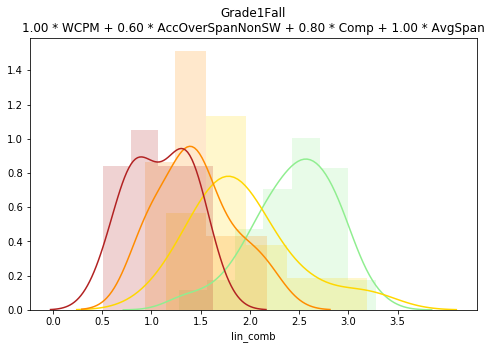

In [105]:
comb_to_average_jaccard = plot_linear_combinations(
    'Grade1Fall',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)

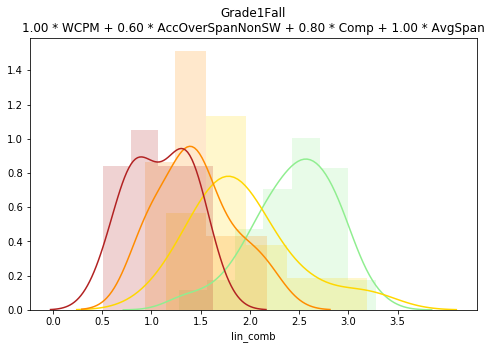

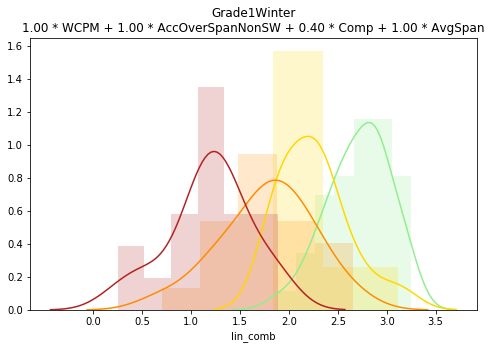

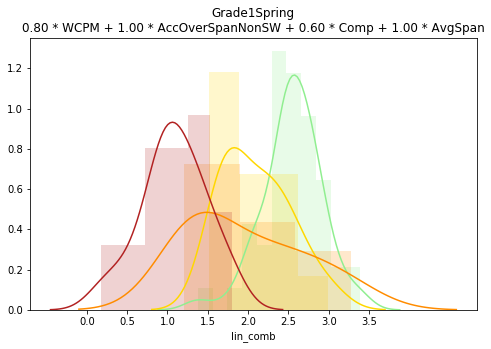

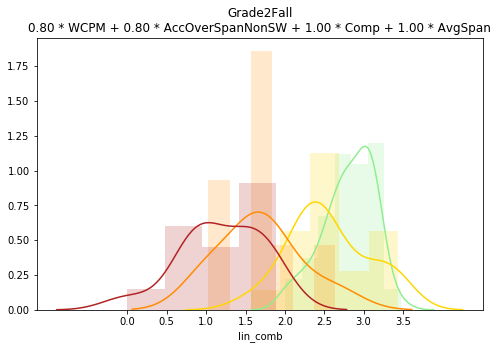

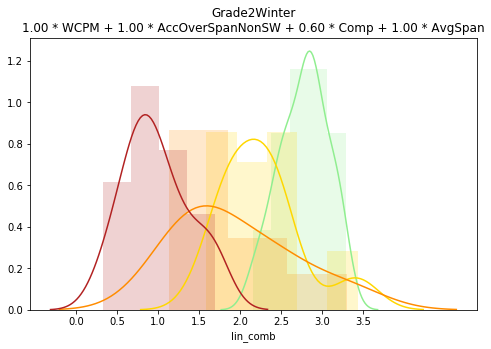

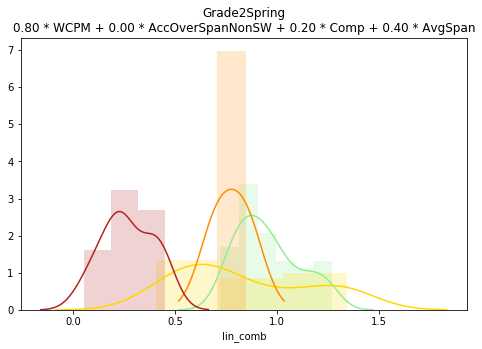

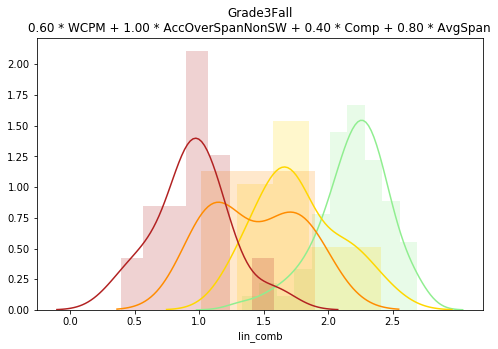

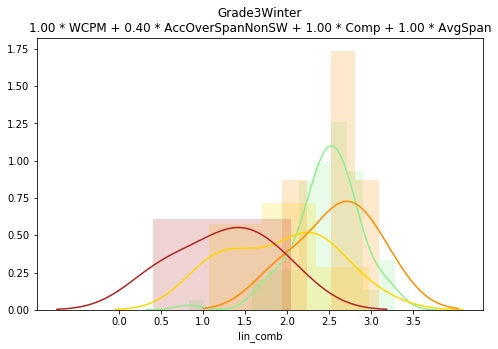

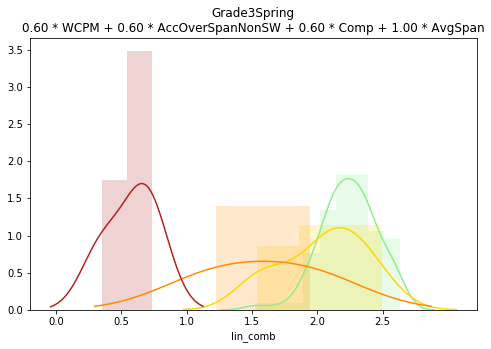

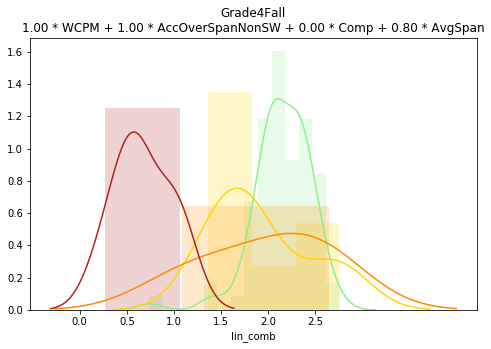

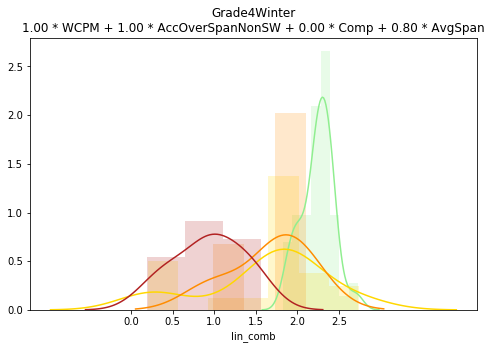

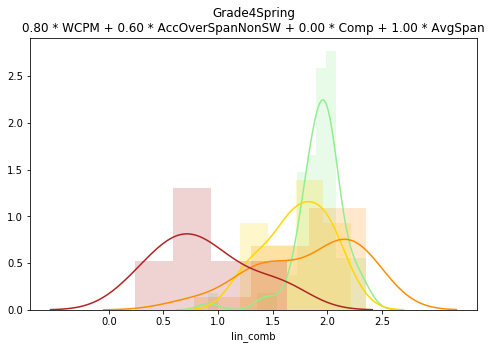

In [109]:
comb_to_average_jaccard = plot_linear_combinations(
    'Grade1Fall',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade1Winter',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade1Spring',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade2Fall',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade2Winter',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade2Spring',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)

comb_to_average_jaccard = plot_linear_combinations(
    'Grade3Fall',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade3Winter',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade3Spring',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)

comb_to_average_jaccard = plot_linear_combinations(
    'Grade4Fall',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade4Winter',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)
    
comb_to_average_jaccard = plot_linear_combinations(
    'Grade4Spring',
    metrics=['WCPM', 'AccOverSpanNonSW', 'Comp', 'AvgSpan'],
    grain=6)

('2.00 * WCPM + 1.33 * Acc4 + 2.00 * Comp + 2.00 * AvgSpan',
 0.11999012709561845)

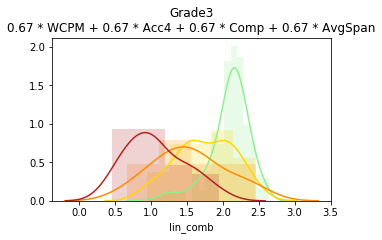

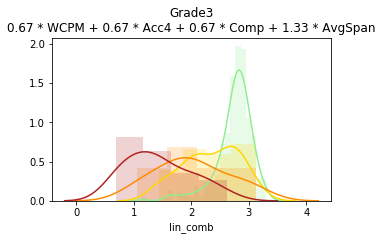

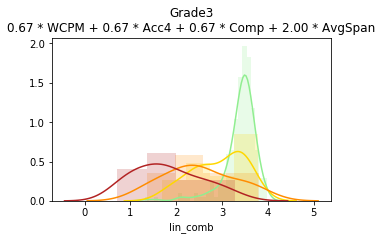

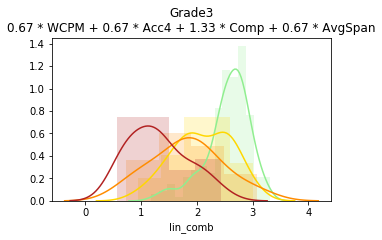

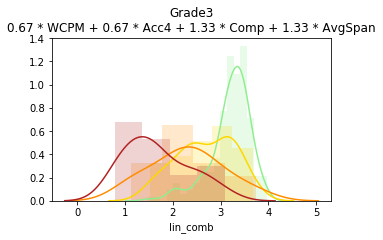

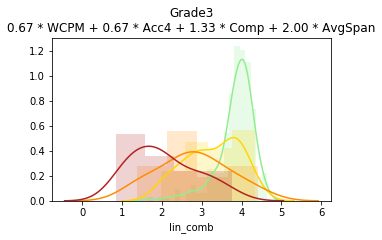

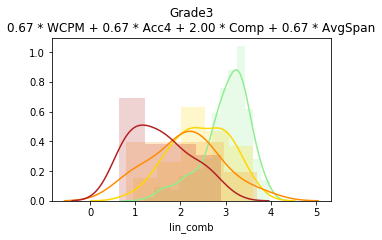

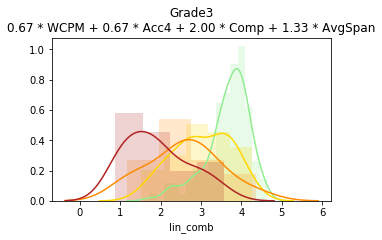

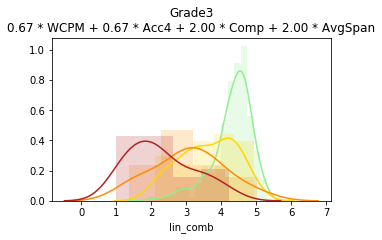

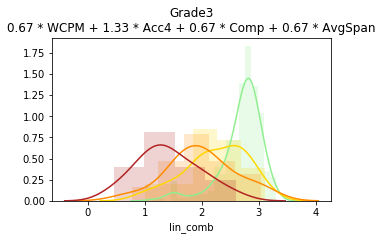

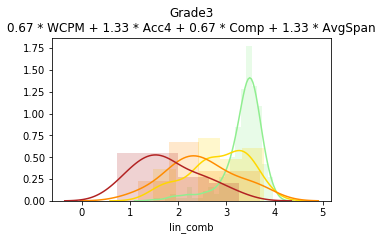

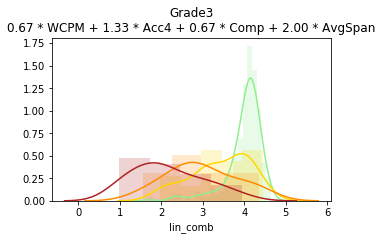

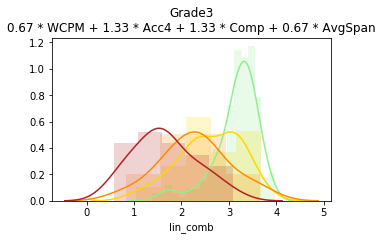

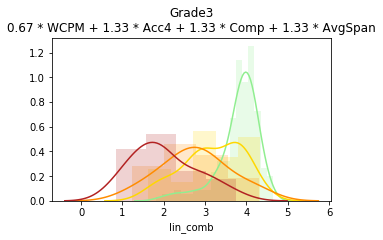

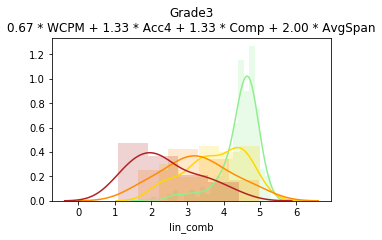

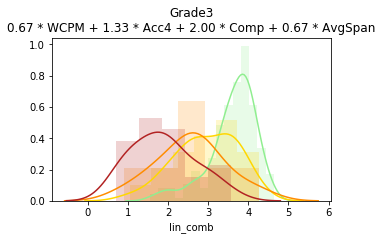

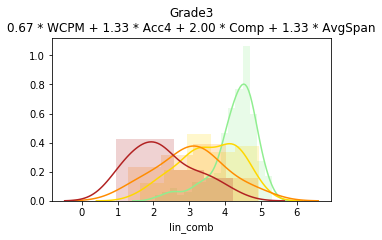

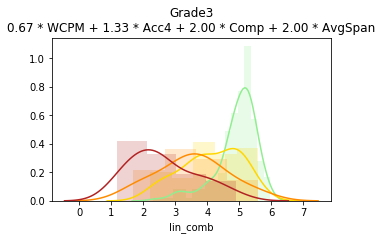

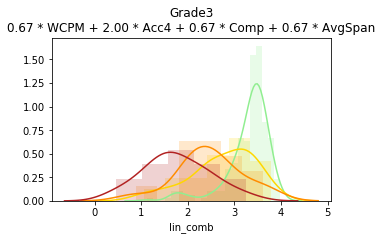

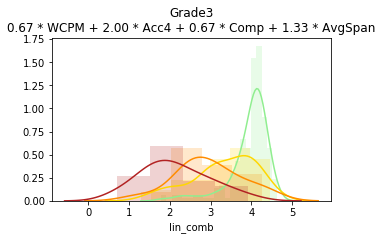

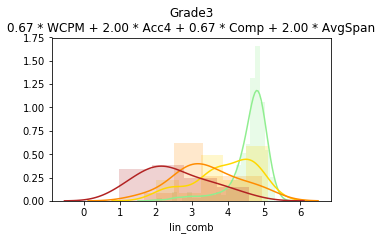

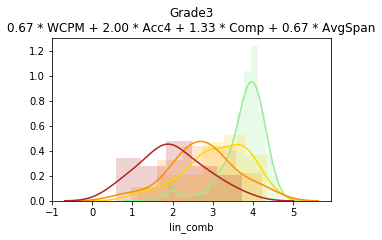

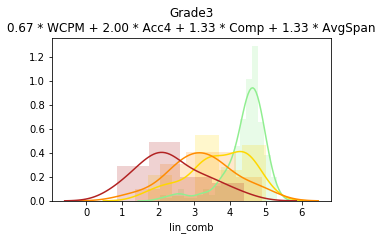

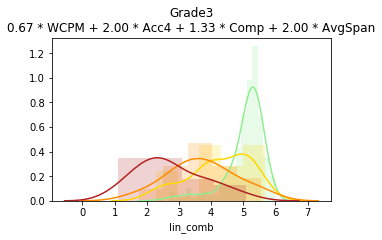

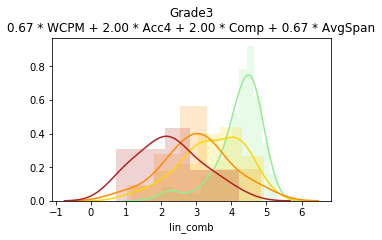

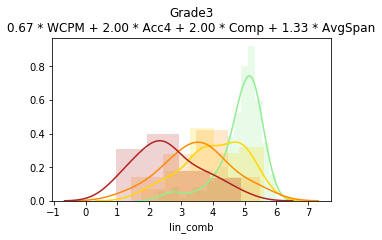

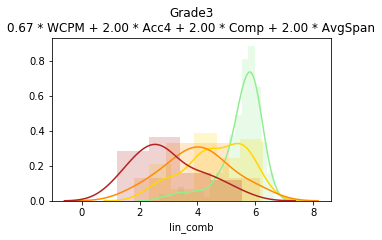

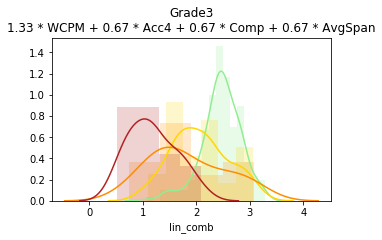

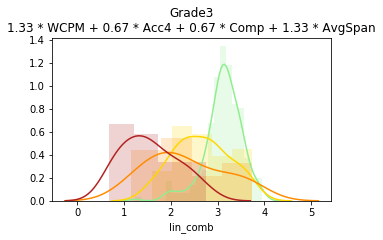

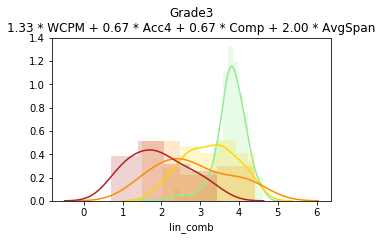

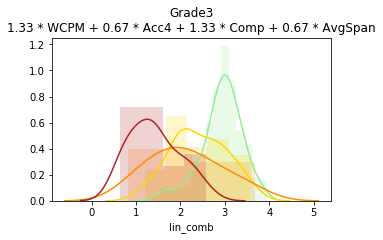

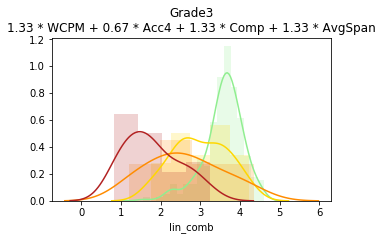

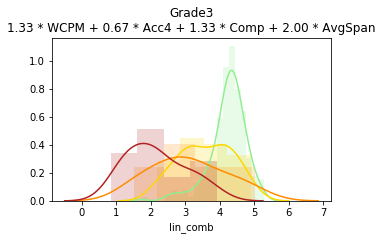

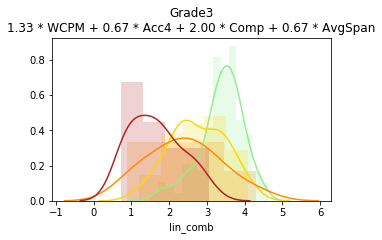

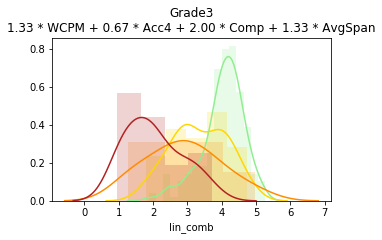

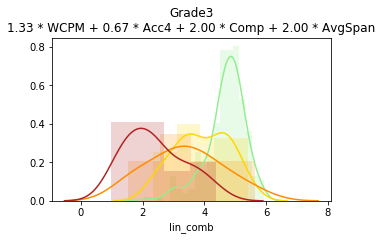

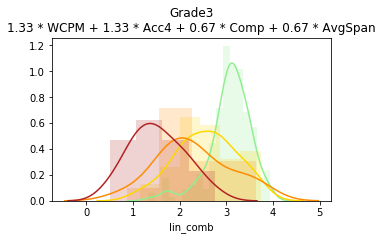

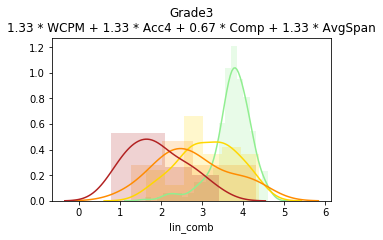

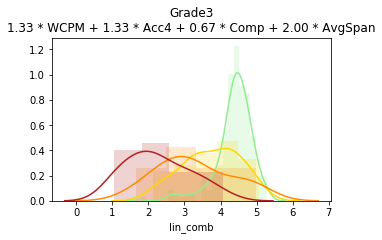

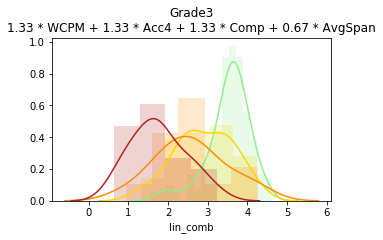

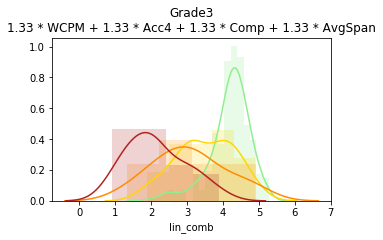

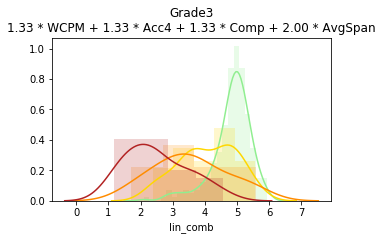

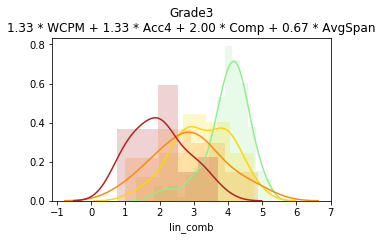

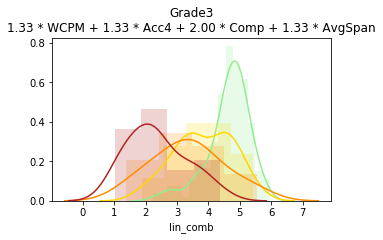

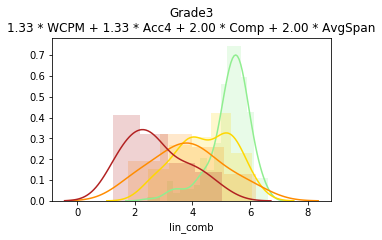

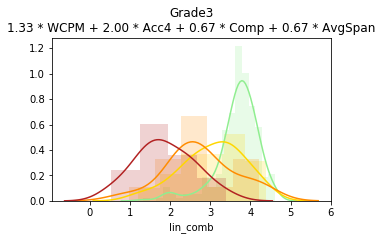

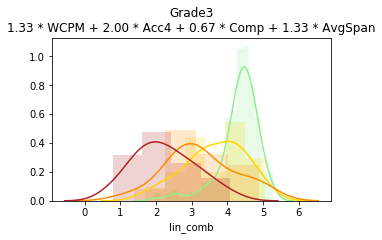

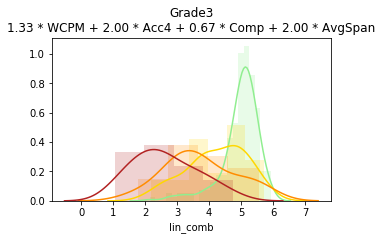

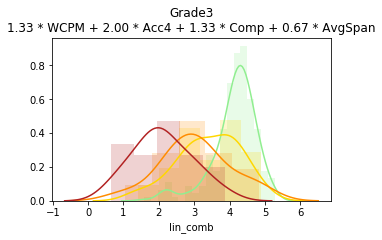

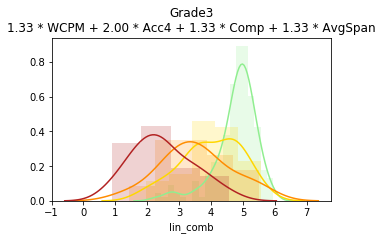

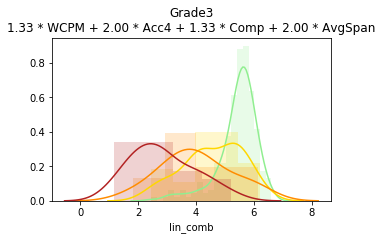

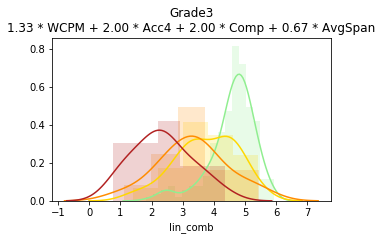

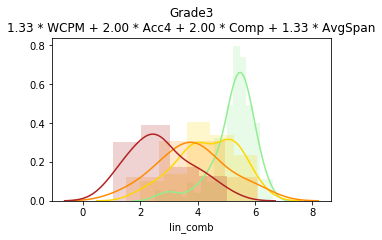

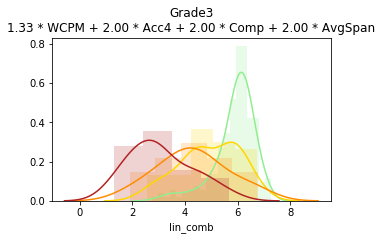

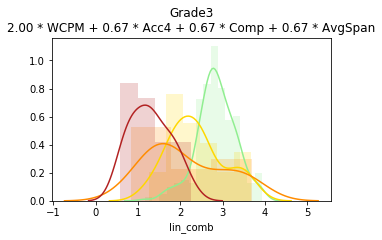

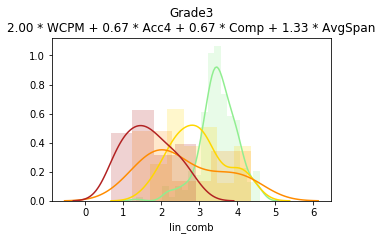

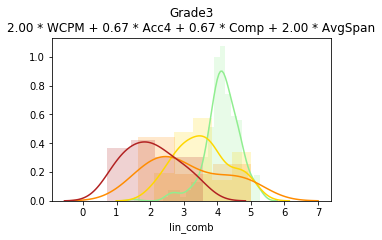

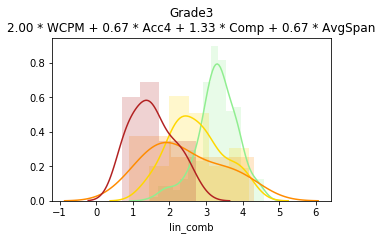

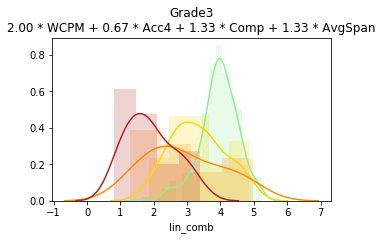

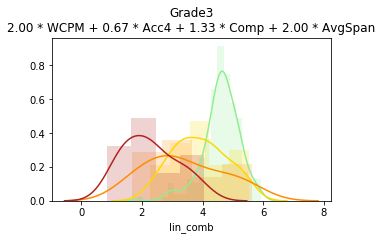

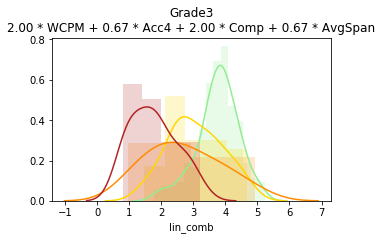

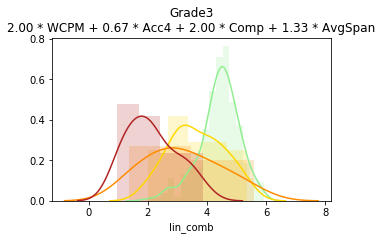

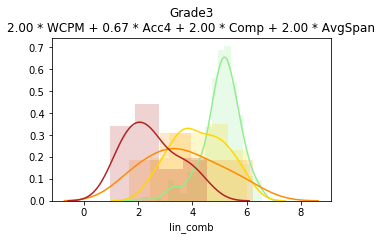

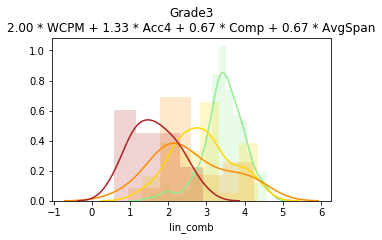

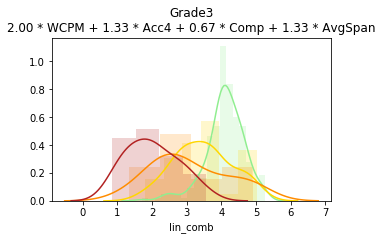

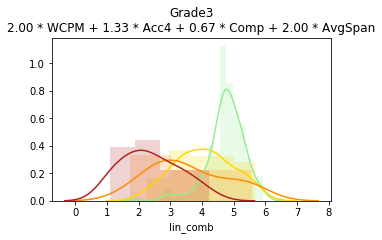

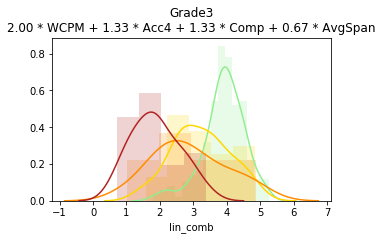

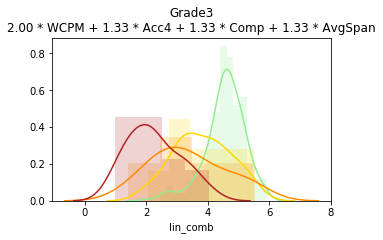

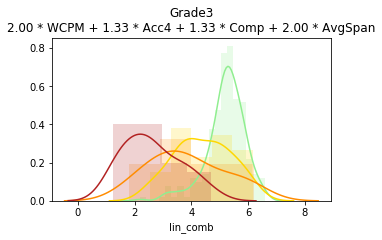

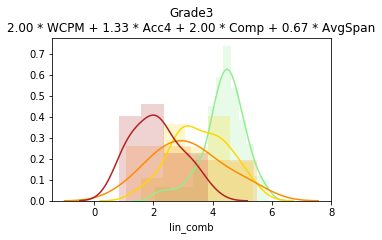

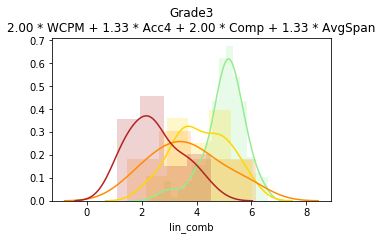

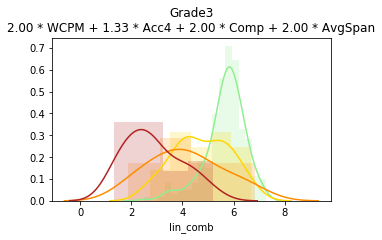

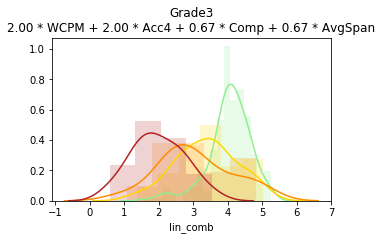

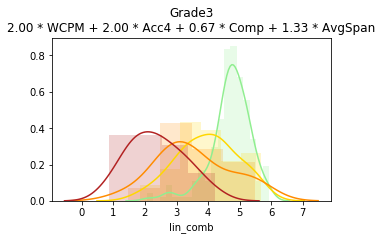

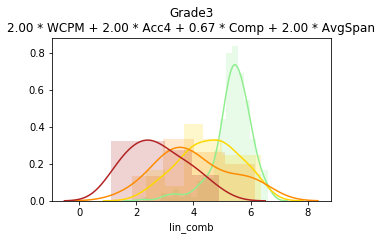

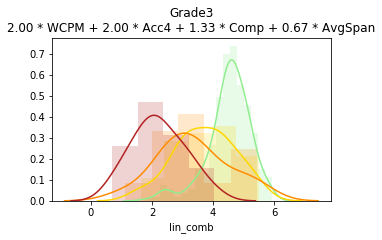

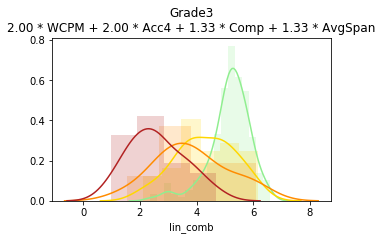

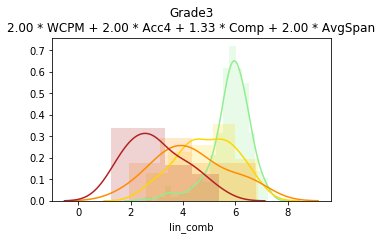

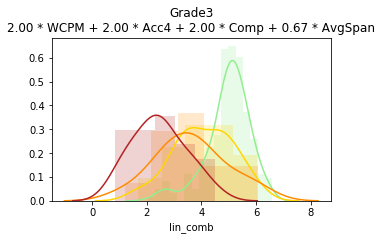

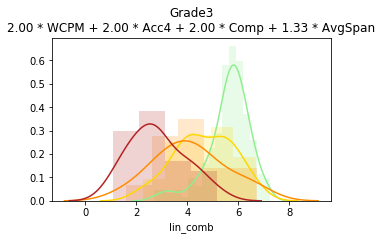

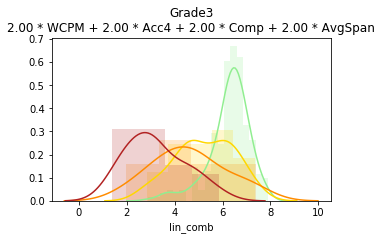

In [7]:
comb_to_average_jaccard = plot_linear_combinations('Grade3', metrics=['WCPM', 'Acc4', 'Comp', 'AvgSpan'], grain=4)
comb_to_average_jaccard

('2.00 * WCPM + 2.00 * Acc4 + 2.00 * Comp + 1.33 * AvgSpan',
 0.1295186941867592)

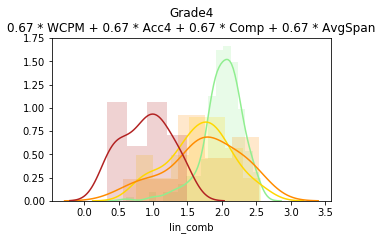

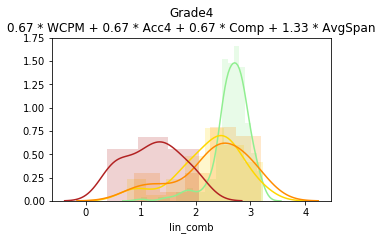

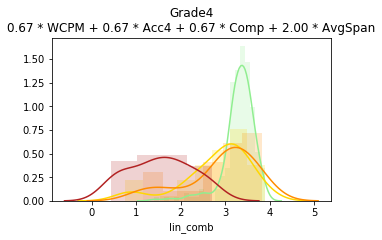

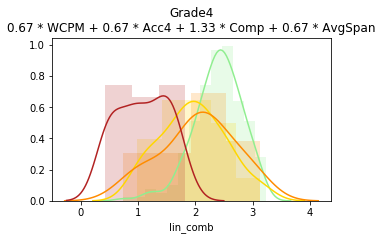

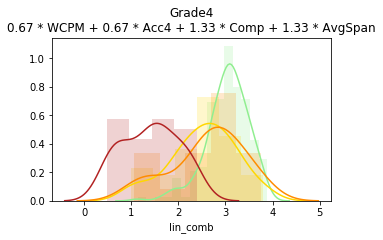

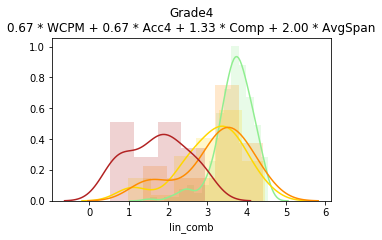

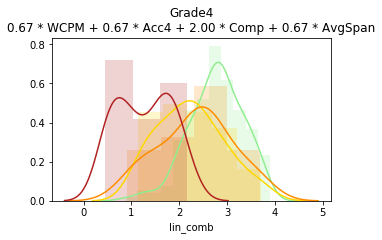

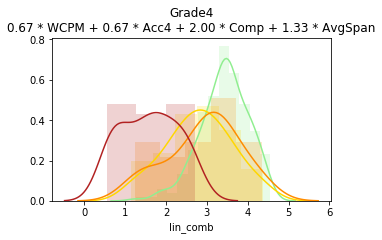

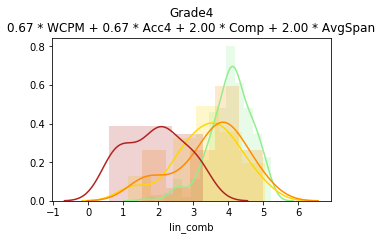

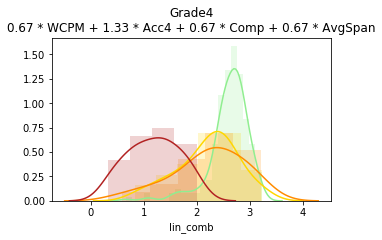

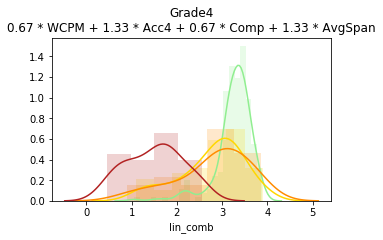

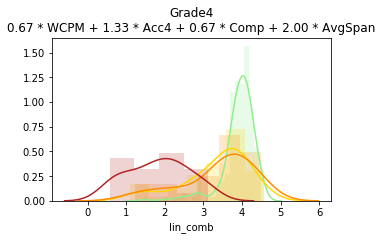

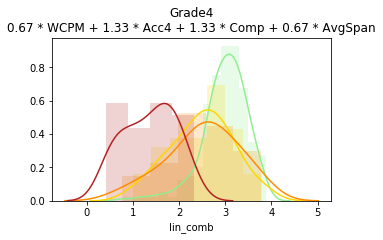

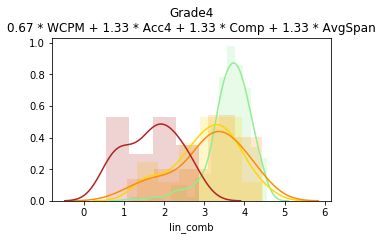

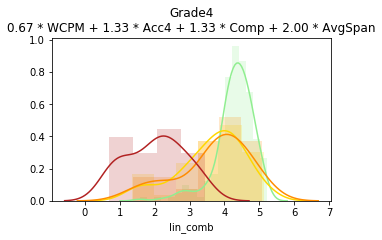

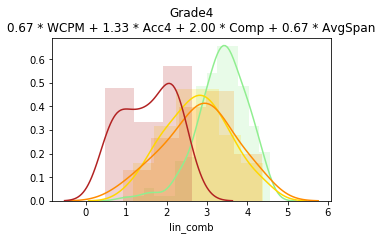

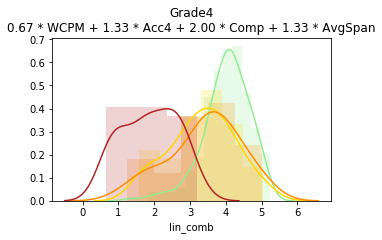

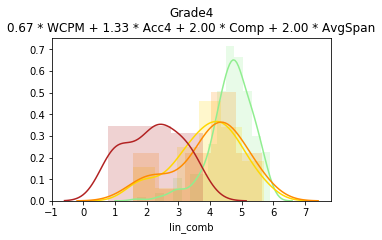

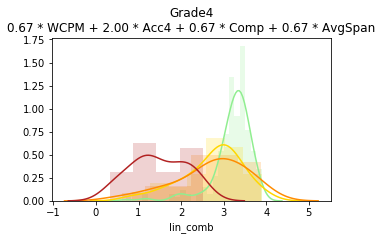

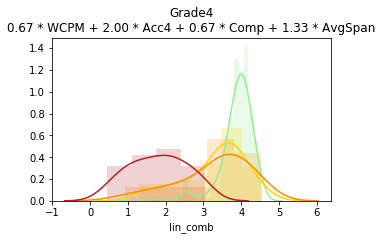

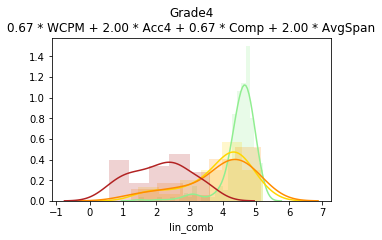

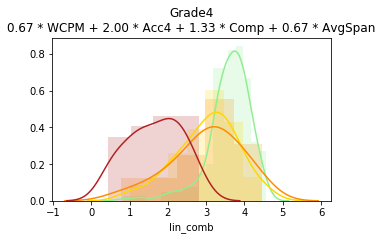

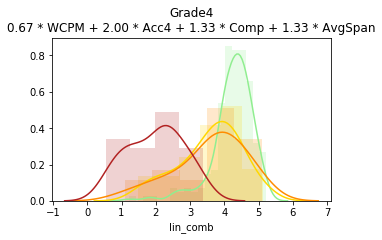

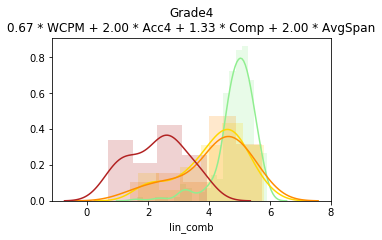

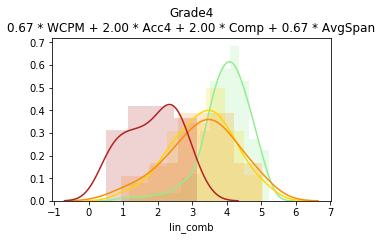

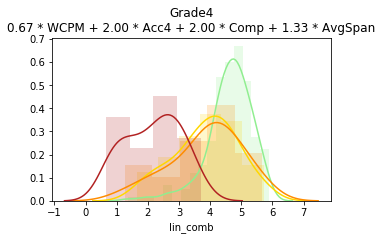

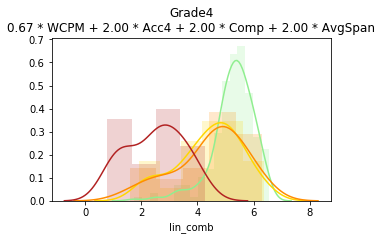

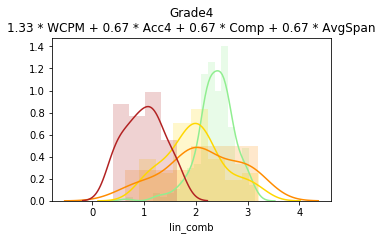

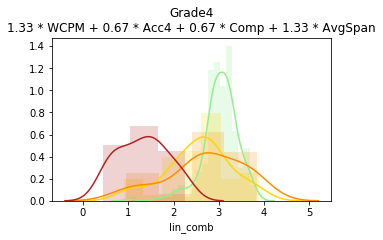

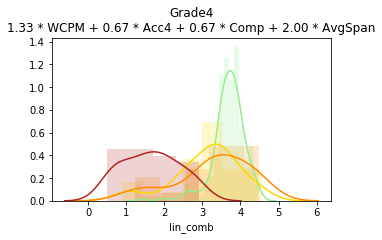

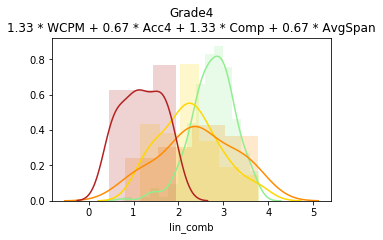

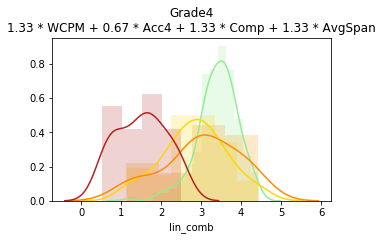

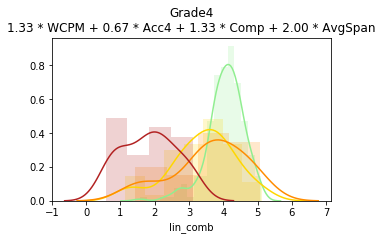

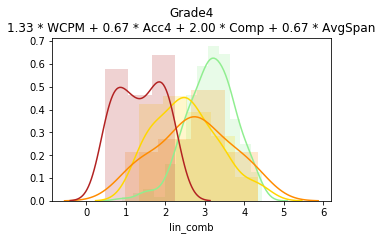

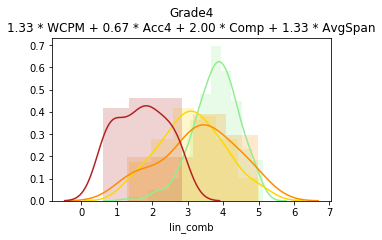

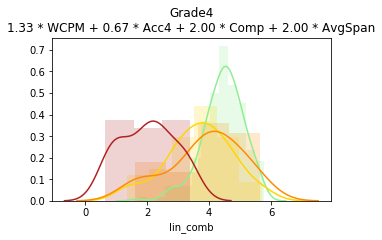

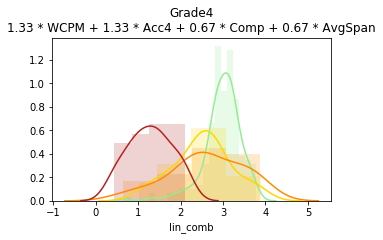

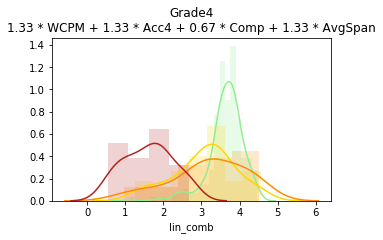

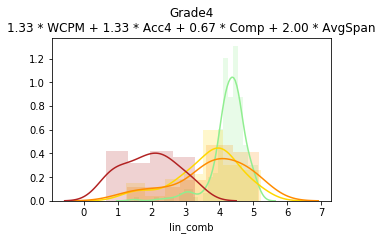

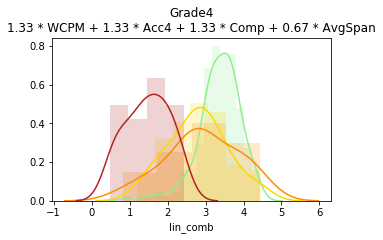

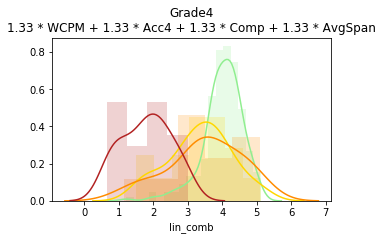

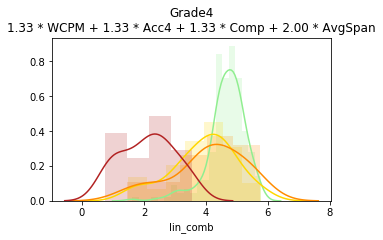

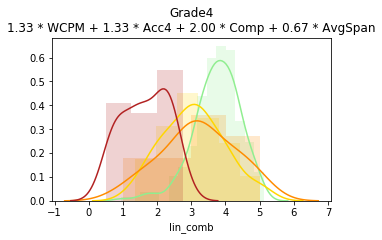

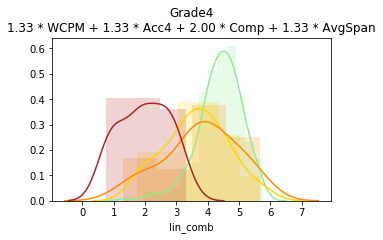

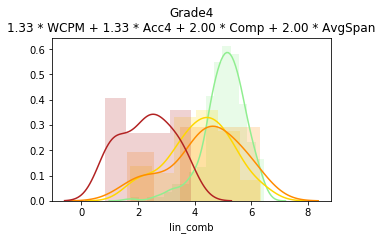

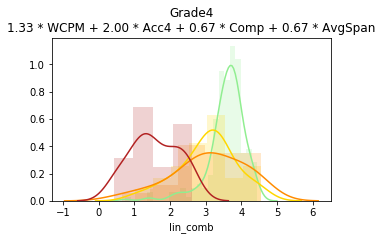

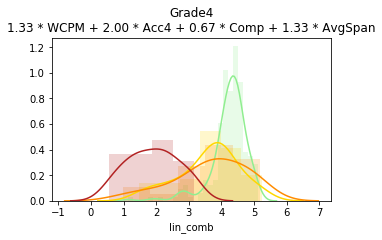

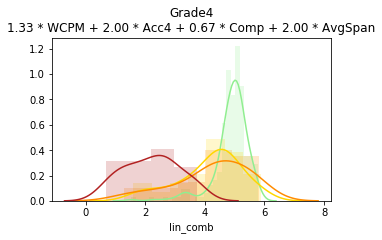

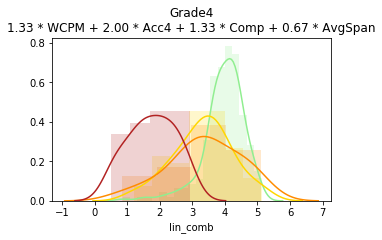

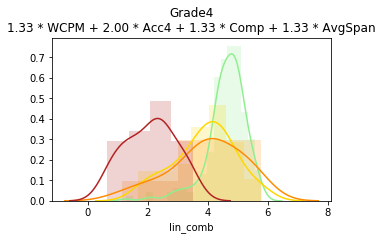

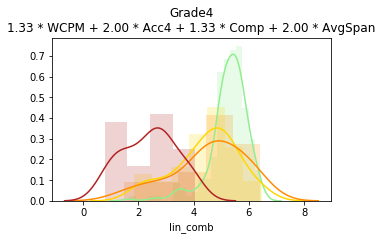

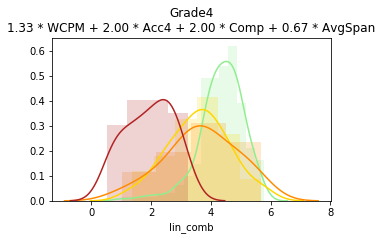

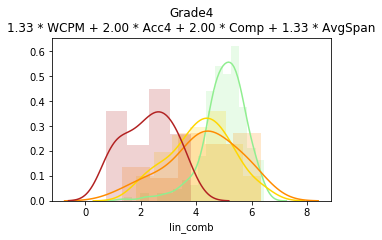

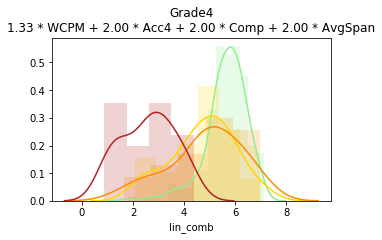

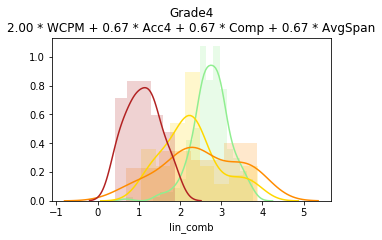

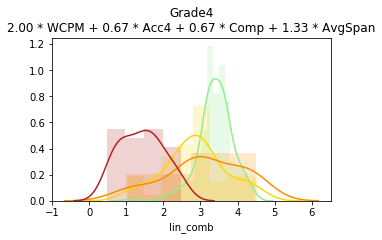

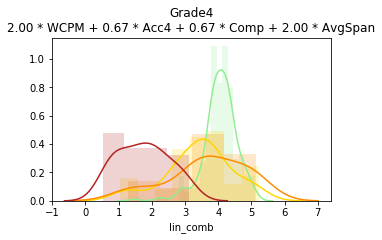

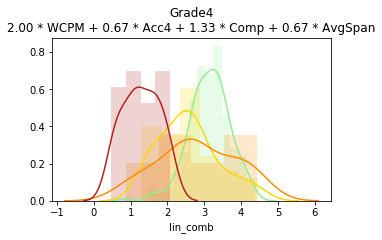

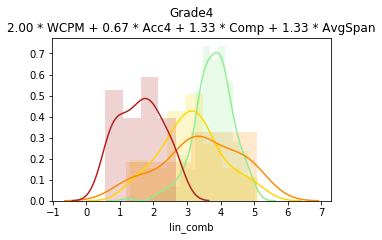

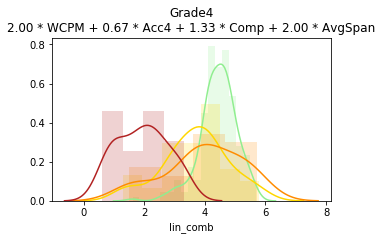

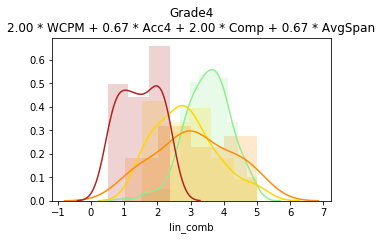

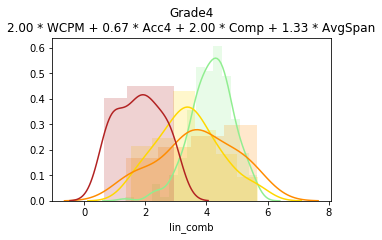

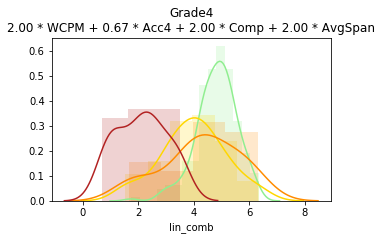

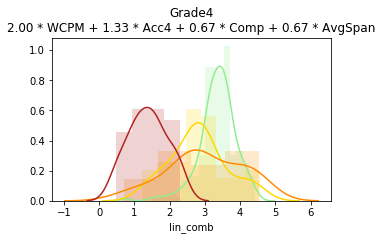

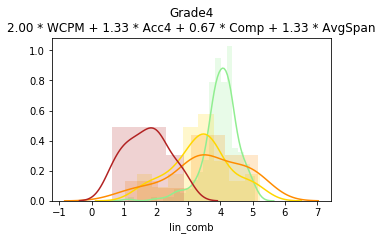

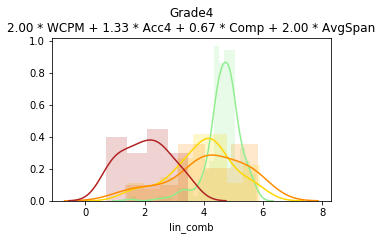

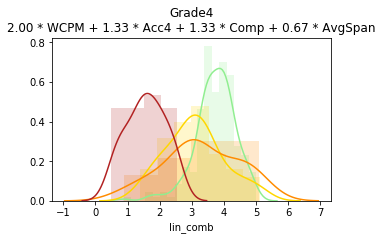

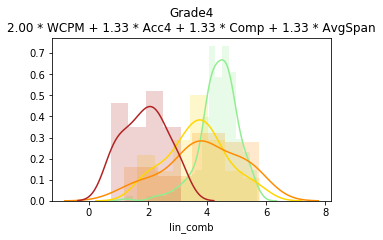

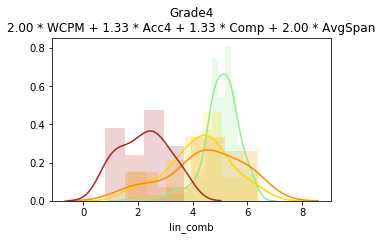

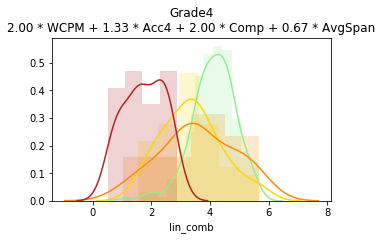

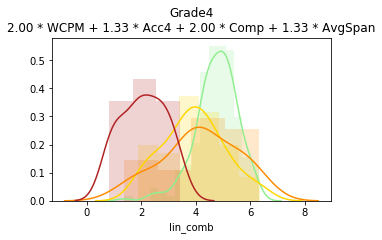

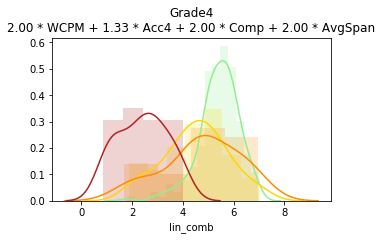

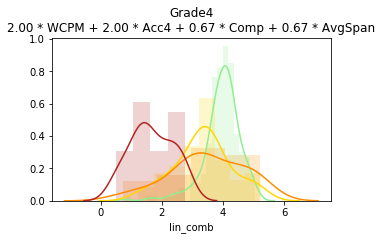

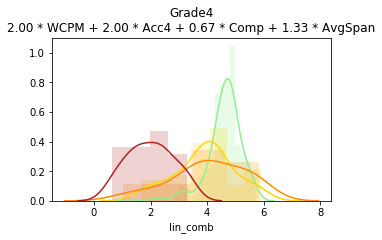

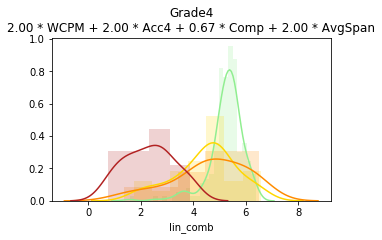

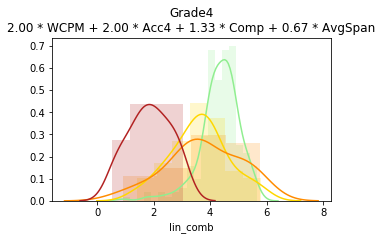

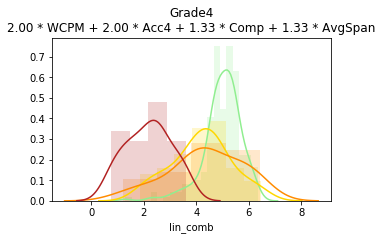

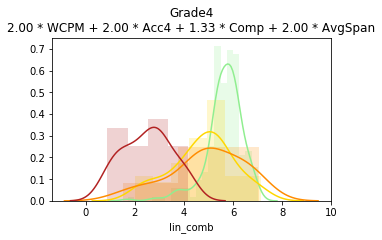

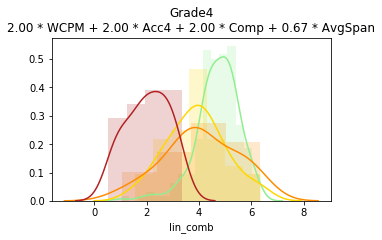

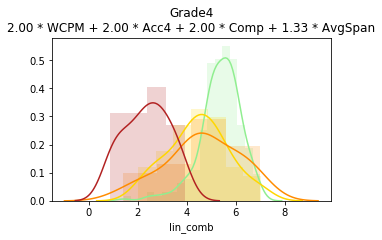

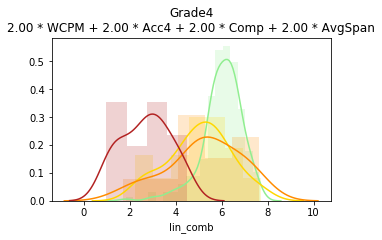

In [8]:
comb_to_average_jaccard = plot_linear_combinations('Grade4', metrics=['WCPM', 'Acc4', 'Comp', 'AvgSpan'], grain=4)
comb_to_average_jaccard